<a href="https://colab.research.google.com/github/tprole/ProduceTV/blob/main/ProduceTV_fromscratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training

In [ ]:
#@title Importing Libraries { vertical-output:false, display-mode: "form" }

import torch
import torchvision
from torchvision import transforms
!git clone https://github.com/tprole/ProduceTV.git
from PIL import Image, ImageOps
import numpy as np
from matplotlib.pyplot import imshow
import cv2

fatal: destination path 'ProduceTV' already exists and is not an empty directory.


In [ ]:
#@title Defining hyperparameters { vertical-output:true, display-mode: "form" }

BATCH_SIZE = 16
learning_rate = 0.001
EPOCHS = 20
numClasses = 131

In [ ]:
#@title Setting up datasets + transforms { vertical-output:true, display-mode: "form" }

from torch.utils import data
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.3), transforms.RandomVerticalFlip(0.1), transforms.ToTensor()])
val_transforms = transforms.Compose([transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()])

trainset = torchvision.datasets.ImageFolder('/content/ProduceTV/fruits-360_dataset/fruits-360/Training/', transform=train_transforms)

#Divide data into training and validation (0.8 and 0.2)
ratio = 0.8
n_train_examples = int(len(trainset) * ratio)
n_val_examples = len(trainset) - n_train_examples

trainset, valset = data.random_split(trainset, [n_train_examples, n_val_examples])

print(f"Number of training samples = {len(trainset)}")
print(f"Number of validation samples = {len(valset)}")


Number of training samples = 54153
Number of validation samples = 13539


In [ ]:
#@title Setting up data loaders { vertical-output:true, display-mode: "form" }

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, num_workers=1)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, num_workers=1)

testset = torchvision.datasets.ImageFolder('/content/ProduceTV/fruits-360_dataset/fruits-360/Test/', transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, num_workers=1, shuffle=False)

Class: 19


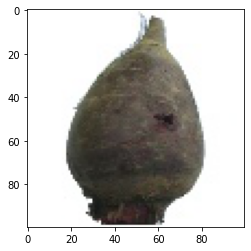

In [ ]:
#@title Showing Image Example { vertical-output:true, display-mode: "form" }

import matplotlib.pyplot as plt
from torch import Tensor

thing = trainset[3][0].numpy()
print("Class: " + str(trainset[3][1]))
plt.imshow(np.transpose(thing, (1, 2, 0)))

In [ ]:
#@title Defining the neural network {vertical-output:true, display-mode:"form"}

from torch import nn
class NeuralNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            
            # nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.LeakyReLU(inplace=True),
            # nn.BatchNorm2d(192),
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(384),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            # nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),
            nn.LeakyReLU(inplace=True)
            )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 1000),
            nn.LeakyReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=256),
            nn.LeakyReLU(inplace=True),
            
            nn.Linear(256, output_dim)
            )
        
    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h
  
# Function to count the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
model=NeuralNet(numClasses)
print(f'The model has {count_parameters(model):,} trainable parameters.')

The model has 11,759,915 trainable parameters.


In [ ]:
#@title Setting up the model { display-mode: "form" }
import torch.optim as optim

# define optimiser and criterion functions
optimiser = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

model.load_state_dict(torch.load('/content/ProduceTV/models/fruitecstatic.pth')) #load model i trained before; so i don't have to train every run of the program

NeuralNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): LeakyReLU(negative_slope=0.01, inplace=True)
    (7): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchN

<All keys matched successfully>

In [ ]:
#@title Function to calculate accuracy { vertical-output:true, display-mode: "form" }

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
#@title Function to perform training of the model { vertical-output:true, display-mode: "form" }

def train(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Train the model
    model.train()
    
    for (images, labels) in loader:
        images = images.cuda()
        labels = labels.cuda()
        
        output, _ = model(images)
        loss = criterion(output, labels)
        
        # Training pass
        opt.zero_grad()
        
        
        # Backpropagation
        loss.backward()
        
        # Calculate accuracy
        acc = calculate_accuracy(output, labels)
        
        # Optimizing weights
        opt.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
#@title Function to evaluate the model's performance {vertical-output:true, display-mode:"form"}
def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0

    #evaluate the model
    model.eval()

    with torch.no_grad():
        for (images, labels) in loader:
            
            images = images.cuda()
            labels = labels.cuda()
            
            
            output, _ = model(images)
            loss = criterion(output, labels)

            acc = calculate_accuracy(output, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
# #@title Training Loop { vertical-output:true, display-mode: "form" }

import time

train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS
val_loss_list = [0]*EPOCHS
val_acc_list = [0]*EPOCHS
val_acc = 0
epoch = 0

# while val_acc < 0.995:
#     epoch = epoch + 1
#     print("Epoch {}: ".format(epoch))
#     train_start_time=time.monotonic()
#     train_loss, train_acc= train(model, trainloader, optimiser, criterion)
#     train_end_time = time.monotonic()

#     val_start_time = time.monotonic()
#     val_loss, val_acc = evaluate(model, valloader, optimiser, criterion)
#     val_end_time = time.monotonic()

#     train_loss_list[epoch] = train_loss
#     train_acc_list[epoch] = train_acc
#     val_loss_list[epoch] = val_loss
#     val_acc_list[epoch] = val_acc

#     print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" %(train_loss, train_acc, train_end_time-train_start_time))
#     print("Validation: Loss = {}, Accuracy = {}, Time = {} seconds".format(val_loss, val_acc, val_end_time - val_start_time))
#     print("")

In [ ]:
#@title Saving the model { vertical-output: true, display-mode: "form" }
# import os
# Create folder to save model
# MODEL_FOLDER = "../Model"
# if not os.path.isdir(MODEL_FOLDER):
#     os.mkdir(MODEL_FOLDER)
    
# PATH_TO_MODEL = MODEL_FOLDER + "/pytorch_classification_alexnetTS.pth"
# if os.path.exists(PATH_TO_MODEL):
#     os.remove(PATH_TO_MODEL)

# torch.save(model.state_dict(), PATH_TO_MODEL)

# print("Model saved at %s" %(PATH_TO_MODEL))

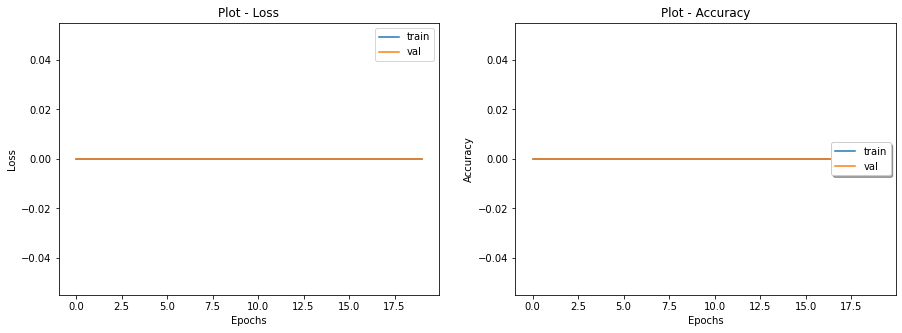

In [ ]:
#@title Plot loss and accuracies for training and validation data { vertical-output: true, display-mode: "form" }

_, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axs[0].plot(train_loss_list, label="train")
axs[0].plot(val_loss_list, label="val")
axs[0].set_title("Plot - Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right', shadow=False)

# Accuracy plot
axs[1].plot(train_acc_list, label="train")
axs[1].plot(val_acc_list, label="val")
axs[1].set_title("Plot - Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right', shadow=True)

As I loaded the trained model weights from a file (I trained the model and then downloaded weights as a .pth file so I can keep the accuracy great!) the graph above shows simply flat lines. Don't be alarmed, it still works just fine ;)

In [ ]:
#@title Generating labels of classes { vertical-output: false, display-mode: "form" }

num = range(numClasses)
labels = []
for i in num:
    labels.append(str(i))
labels = sorted(labels)
for i in num:
    labels[i] = int(labels[i])
print("List of labels : ")
print("Actual labels \t--> Class in PyTorch")
for i in num:
    print("\t%d \t--> \t%d" % (labels[i], i))

List of labels : 
Actual labels 	--> Class in PyTorch
	0 	--> 	0
	1 	--> 	1
	10 	--> 	2
	100 	--> 	3
	101 	--> 	4
	102 	--> 	5
	103 	--> 	6
	104 	--> 	7
	105 	--> 	8
	106 	--> 	9
	107 	--> 	10
	108 	--> 	11
	109 	--> 	12
	11 	--> 	13
	110 	--> 	14
	111 	--> 	15
	112 	--> 	16
	113 	--> 	17
	114 	--> 	18
	115 	--> 	19
	116 	--> 	20
	117 	--> 	21
	118 	--> 	22
	119 	--> 	23
	12 	--> 	24
	120 	--> 	25
	121 	--> 	26
	122 	--> 	27
	123 	--> 	28
	124 	--> 	29
	125 	--> 	30
	126 	--> 	31
	127 	--> 	32
	128 	--> 	33
	129 	--> 	34
	13 	--> 	35
	130 	--> 	36
	14 	--> 	37
	15 	--> 	38
	16 	--> 	39
	17 	--> 	40
	18 	--> 	41
	19 	--> 	42
	2 	--> 	43
	20 	--> 	44
	21 	--> 	45
	22 	--> 	46
	23 	--> 	47
	24 	--> 	48
	25 	--> 	49
	26 	--> 	50
	27 	--> 	51
	28 	--> 	52
	29 	--> 	53
	3 	--> 	54
	30 	--> 	55
	31 	--> 	56
	32 	--> 	57
	33 	--> 	58
	34 	--> 	59
	35 	--> 	60
	36 	--> 	61
	37 	--> 	62
	38 	--> 	63
	39 	--> 	64
	4 	--> 	65
	40 	--> 	66
	41 	--> 	67
	42 	--> 	68
	43 	--> 	69
	44 	--> 	70
	45 	--

In [ ]:
#@title Accuracy Calculation { vertical-output: true, display-mode: "form" }

# This code will be hidden when the notebook is loaded.

#PREVIOUSLY CALCULATED ACCURACY
accuracy = 0.9752291960507757

print("Accuracy:", accuracy)
#print("Accuracy: " + str(evaluate(model, testloader, optimiser, criterion)[1]))

Accuracy: 0.9752291960507757


In [ ]:
#@title Function to get predictions { vertical-output:true, display-mode:'form' }

def get_prediction(set, index):
    filename = set[index][0]
    # print(set[index][1])
    pil_image = transforms.ToPILImage()
    image = pil_image(filename)
    
    # image = PIL.Image.open(filename)
    size = (224, 224)
    # image = ImageOps.fit(image, size, Image.ANTIALIAS)
    image = ImageOps.fit(image, size)

    #turn the image into a readable tensor
    image_array = test_transforms(image)
    tensor = image_array.unsqueeze(1)
    tensor = tensor.permute(1, 0, 3, 2)
    tensor = tensor.cuda()
    # print(tensor.shape)

    # run the inference
    prediction, _ = model(tensor)
    classNum = int(torch.argmax(prediction))
    return classNum, set[index][1], image


In [ ]:
#@title Class Dictionary { vertical-output: true, display-mode:"form" }

produceClasses = {
    0: 'apple',
    1: 'apple',
    2: 'apple',
    3: 'apple',
    4: 'apple',
    5: 'apple',
    6: 'apple',
    7: 'apple',
    8: 'apple',
    9: 'apple',
    10: 'apple',
    11: 'apple',
    12: 'apple',
    # 2: 'golden apple',
    # 3: 'golden apple',
    # 4: 'golden apple',
    # 5: 'granny smith apple',
    # 6: 'pink lady apple',
    # 7: 'red apple',
    # 8: 'red apple',
    # 9: 'red apple',
    # 10: 'red delicious apple',
    # 11: 'red yellow apple',
    # 12: 'red yellow apple',
    13: 'apricot',
    14: 'avocado',
    15: 'avocado ripe',
    16: 'banana',
    17: 'banana lady finger',
    18: 'banana red',
    19: 'beetroot',
    20: 'blueberry',
    21: 'cactus fruit',
    22: 'cantaloupe',
    23: 'cantaloupe',
    24: 'carambula',
    25: 'cauliflower',
    26: 'cherry',
    27: 'cherry',
    28: 'cherry rainier',
    29: 'cherry wax black',
    30: 'cherry wax red',
    31: 'cherry wax yellow',
    32: 'chestnut',
    33: 'clementine',
    34: 'cocos',
    35: 'corn',
    36: 'corn husk',
    37: 'cucumber',
    38: 'cucumber',
    39: 'dates',
    40: 'eggplant',
    41: 'fig',
    42: 'ginger root',
    43: 'granadilla',
    44: 'grape blue',
    45: 'grape pink',
    46: 'grape white',
    47: 'grape white',
    48: 'grape white',
    49: 'grape white',
    50: 'grapefruit pink',
    51: 'grapefruit white',
    52: 'guava',
    53: 'hazelnut',
    54: 'huckleberry',
    55: 'kaki',
    56: 'kiwi',
    57: 'kohlrabi',
    58: 'kumquats',
    59: 'lemon',
    60: 'lemon meyer',
    61: 'lime',
    62: 'lychee',
    63: 'mandarin',
    64: 'mango',
    65: 'mango red',
    66: 'mangostan',
    67: 'maracuja',
    68: 'melon piel de sapo',
    69: 'mulberry',
    70: 'nectarine',
    71: 'nectarine flat',
    72: 'nut forest',
    73: 'nut pecan',
    74: 'onion red',
    75: 'onion red',
    76: 'onion white',
    77: 'orange',
    78: 'papaya',
    79: 'passion fruit',
    80: 'peach',
    81: 'peach',
    82: 'peach flat',
    83: 'pear',
    84: 'pear',
    85: 'pear abate',
    86: 'pear forelle',
    87: 'pear kaiser',
    88: 'pear monster',
    89: 'pear red',
    90: 'pear stone',
    91: 'pear williams',
    92: 'pepino',
    93: 'pepper green',
    94: 'pepper orange',
    95: 'pepper red',
    96: 'pepper yellow',
    97: 'physalis',
    98: 'physalis with husk',
    99: 'pineapple',
    100: 'pineapple mini',
    101: 'pitahaya red',
    102: 'plum',
    103: 'plum',
    104: 'plum',
    105: 'pomegranate',
    106: 'pomelo sweetie',
    107: 'potato red',
    108: 'potato red',
    109: 'sweet potato',
    110: 'potato white',
    111: 'quince',
    112: 'rambutan',
    113: 'raspberry',
    114: 'redcurrant',
    115: 'salak',
    116: 'strawberry',
    117: 'strawberry',
    118: 'tamarillo',
    119: 'tangelo',
    120: 'tomato',
    121: 'tomato',
    122: 'tomato',
    123: 'tomato',
    124: 'cherry tomato',
    125: 'tomato heart',
    126: 'tomato maroon',
    127: 'tomato yellow',
    128: 'tomato not ripened',
    129: 'walnut',
    130: 'watermelon',
}

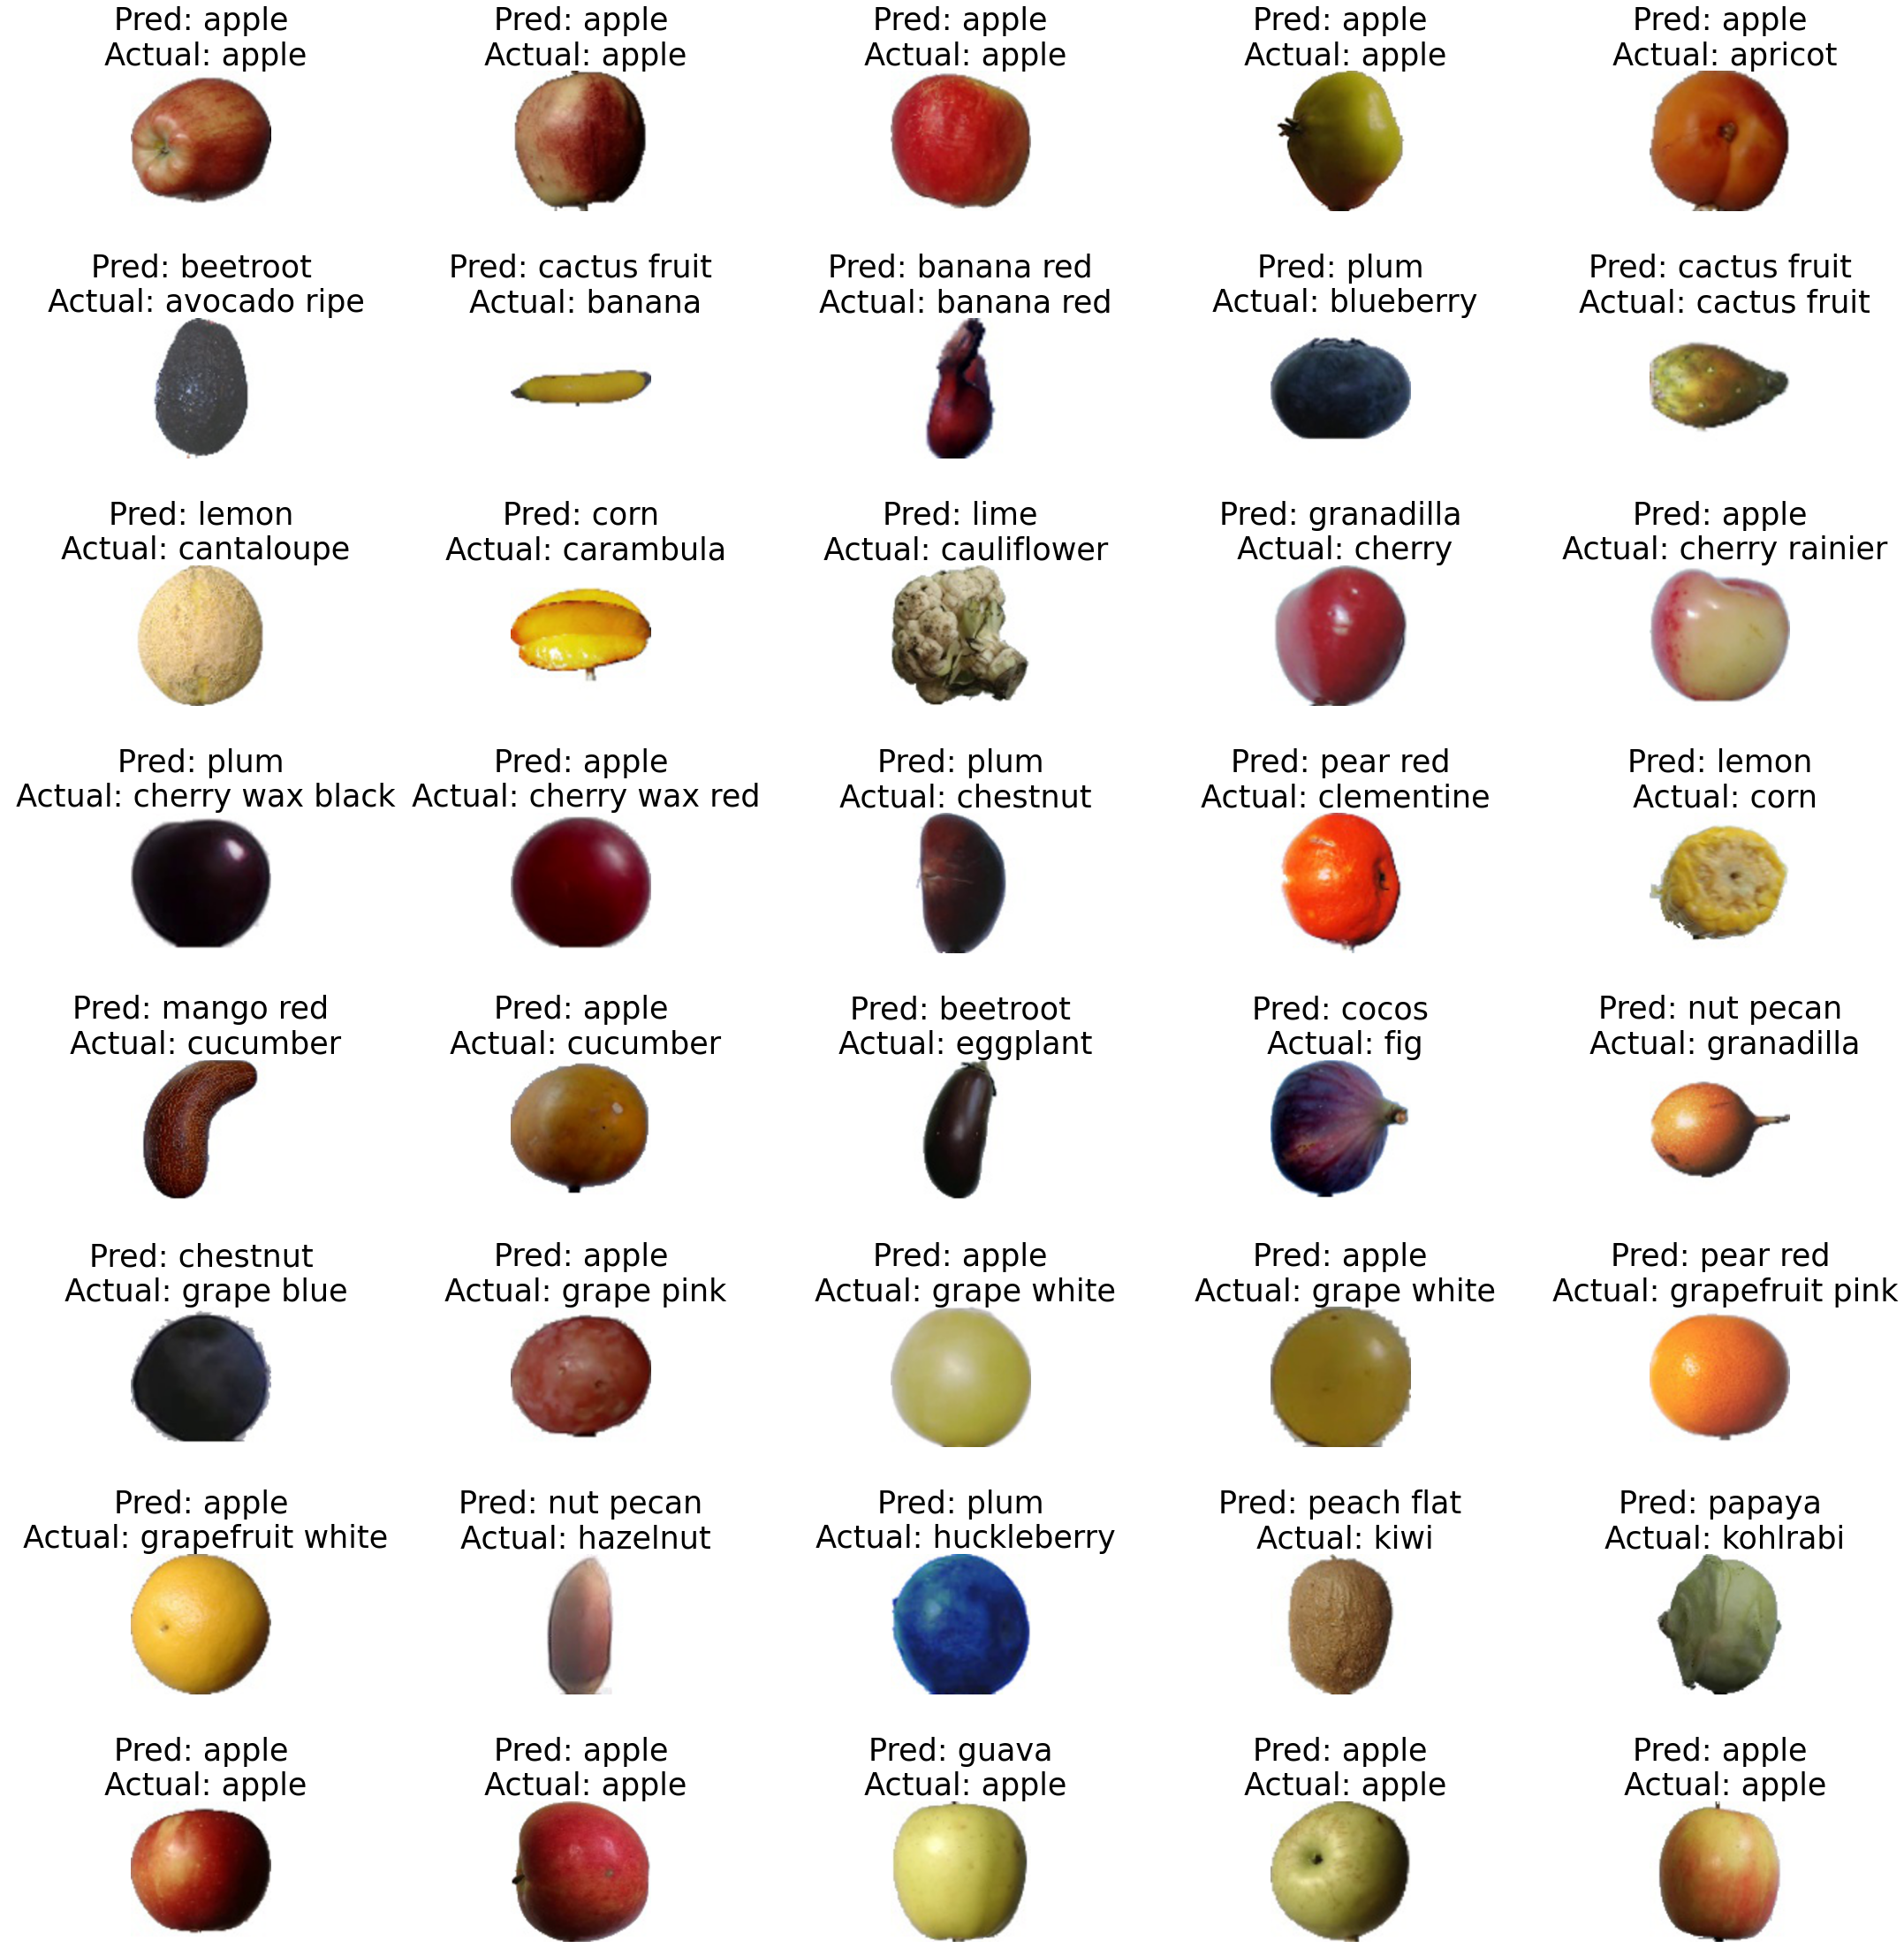

In [ ]:
#@title Display Images { vertical-output: true, display-mode: "form" }

# Display some images, along with the actual and predicted classes

import PIL
from PIL import Image
fig, axs = plt.subplots(8,5,figsize=(30,30))
plt.axis('off')
fig.tight_layout(h_pad = 10)
col = -1
row = -1
for i in range(1, 10000, 250):
    if col == 4:
      row = row + 1
      col = -1
    col = col + 1

    pred = get_prediction(testset, i)
    prediction = pred[0]
    groundtruth = pred[1]
    image = pred[2]

    axs[row, col].imshow(image)

    title = "Pred: {}\n Actual: {}".format(produceClasses[pred[0]], produceClasses[pred[1]])
    axs[row, col].axis('off')
    axs[row, col].set_title(title, fontsize=35)

plt.savefig("predictions.png", bbox_inches = 'tight', pad_inches=0.5)

# Application

In [ ]:
#@title Importing Files + Libraries { vertical-output:true, display-mode:"form"}
import torch
!git clone https://github.com/tprole/ProduceTV.git

fatal: destination path 'ProduceTV' already exists and is not an empty directory.


In [ ]:
#@title Webcam capture function { vertical-output:true, display-mode:"form" }

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Saved to /content/ProduceTV/fruits-360_dataset/fruits-360/Training/Apple Crimson Snow/0_100.jpg


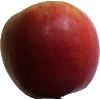

torch.Size([1, 3, 100, 100])
1
This is a apple!


In [ ]:
#@title Input Type { run: "auto", vertical-output: true, display-mode: "form" }
#@markdown Choose how to input your image. 


Type = "test input" #@param ["webcam", "test input"] {allow-input: false}


import PIL

# Replace this with the path to your image
from IPython.display import Image

if Type == "test input":
  try:
    filename = '/content/ProduceTV/fruits-360_dataset/fruits-360/Training/Apple Crimson Snow/0_100.jpg'
    print('Saved to {}'.format(filename))
    
    # Show the image which was just taken.
    display(Image(filename))
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

elif Type == "webcam":
  try:
    filename = take_photo()
    print('Saved to {}'.format(filename))
    
    # Show the image which was just taken.
    display(Image(filename))
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

image = PIL.Image.open(filename)
#resize the image to a 224x224 with the same strategy as in TM2:
#resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size)

#turn the image into a readable tensor
image_array = test_transforms(image)
tensor = image_array.unsqueeze(1)
tensor = tensor.permute(1, 0, 3, 2)
tensor = tensor.cuda()
print(tensor.shape)

# run the inference
prediction, _ = model(tensor)
classNum = int(torch.argmax(prediction))
print(classNum)
print("This is a {}!".format(produceClasses[classNum]))

food = produceClasses[classNum]

# Recipe QR Codes

This part of the program takes the output of the neural network and shows a QR code link to recipes that can be made at home with that type of produce item. As of right now only select produce item recipes are available, but more may be added in the future depending on demand. The exemplar here outputs a QR code that links to a webpage with recipes that can be made with apples, since an apple was detected in the input image above.

In [ ]:
print(food)

apple


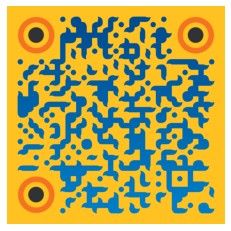

In [ ]:
#@title Recipe QR Code { vertical-output:true, display-mode:"form" }



qr_path = str('/content/ProduceTV/QR-codes/' + food + "-qr.png")
plt.axis('off')
try:
  qrcode = PIL.Image.open(qr_path)
  plt.imshow(qrcode)
except:
  print("Recipes not yet available for this food.")